# TDS experiment

In [1]:
import festim as F
import numpy as np


my_model = F.HydrogenTransportProblem()

# -------- Mesh --------- #

L = 20e-6
vertices = np.concatenate(
    [
        np.linspace(0, 30e-9, num=200, endpoint=False),
        np.linspace(30e-9, 3e-6, num=300, endpoint=False),
        np.linspace(3e-6, L, num=200),
    ]
)
my_model.mesh = F.Mesh1D(vertices)


# -------- Materials and subdomains --------- #

w_atom_density = 6.3e28  # atom/m3

tungsten = F.Material(D_0=4.1e-7, E_D=0.39, name="tungsten")

my_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, L], material=tungsten)
left_surface = F.SurfaceSubdomain1D(id=1, x=0)
right_surface = F.SurfaceSubdomain1D(id=2, x=L)

my_model.subdomains = [
    my_subdomain,
    left_surface,
    right_surface,
]

# -------- Hydrogen species and reactions --------- #

mobile_H = F.Species("H")
trapped_H1 = F.Species("trapped_H1", mobile=False)
empty_trap1 = F.ImplicitSpecies(
    n=1.3e-3 * w_atom_density, others=[trapped_H1], name="empty_trap1"
)
trapped_H2 = F.Species("trapped_H2", mobile=False)
empty_trap2 = F.ImplicitSpecies(
    n=4e-3 * w_atom_density, others=[trapped_H2], name="empty_trap2"
)
my_model.species = [mobile_H, trapped_H1, trapped_H2]

my_model.reactions = [
    F.Reaction(
        k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=0.87,
        reactant=[mobile_H, empty_trap1],
        product=trapped_H1,
        volume=my_subdomain,
    ),
    F.Reaction(
        k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.0,
        reactant=[mobile_H, empty_trap2],
        product=trapped_H2,
        volume=my_subdomain,
    ),
]

# -------- Temperature --------- #

implantation_time = 400
start_tds = implantation_time + 50
implantation_temp = 300
temperature_ramp = 8  # K/s


def temp_function(t):
    if t < start_tds:
        return implantation_temp
    else:
        return implantation_temp + temperature_ramp * (t - start_tds)


my_model.temperature = temp_function

# -------- Boundary conditions --------- #


def left_conc_value(t):
    if t < implantation_time:
        _T = temp_function(t)
        D = tungsten.D_0 * np.exp(-tungsten.E_D / F.k_B / _T)
        return 2.5e19 * 4.5e-9 / D
    else:
        return 0.0


my_model.boundary_conditions = [
    F.DirichletBC(subdomain=left_surface, value=left_conc_value, species=mobile_H),
    F.DirichletBC(subdomain=right_surface, value=0, species=mobile_H),
]

# -------- Exports --------- #

left_flux = F.SurfaceFlux(field=mobile_H, surface=left_surface)
right_flux = F.SurfaceFlux(field=mobile_H, surface=right_surface)

my_model.exports = [
    # F.VTXExport("mobile_concentration_h.bp", field=mobile_H),
    # F.VTXExport("trapped_concentration_h.bp", field=trapped_H1),
    F.XDMFExport("mobile_concentration_h.xdmf", field=mobile_H),
    F.XDMFExport("trapped_concentration_h1.xdmf", field=trapped_H1),
    F.XDMFExport("trapped_concentration_h2.xdmf", field=trapped_H2),
    left_flux,
    right_flux,
]

# -------- Settings --------- #

my_model.settings = F.Settings(atol=1e10, rtol=1e-10, max_iterations=30, final_time=500)

my_model.settings.stepsize = F.Stepsize(initial_value=0.5)

# -------- Run --------- #

my_model.initialise()
my_model.run()

# -------- Save results --------- #

np.savetxt(
    "outgassing_flux_tds.txt",
    np.array(left_flux.data) + np.array(right_flux.data),
)
np.savetxt("times_tds.txt", np.array(left_flux.t))

Solving H transport problem:   0%|          | 0.00/500 [00:00<?, ?it/s]

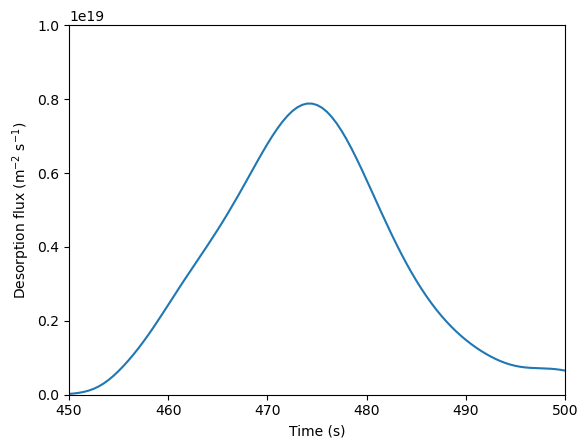

In [2]:
import matplotlib.pyplot as plt
import numpy as np

times = np.genfromtxt("times_tds.txt")
flux = np.genfromtxt("outgassing_flux_tds.txt")
flux = np.abs(flux)

plt.figure()
plt.plot(times, flux)
plt.xlim(450, 500)
# plt.ylim(top=1e18)
plt.ylim(bottom=0, top=1e19)
# plt.ylim(bottom=1.25e18, top=0.6e19)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")
plt.show()